In [91]:
import sys 
import os
sys.path.append(os.path.relpath("../../src/"))
from network import * # my class
import pandas as pd
import numpy as np
import networkx as nx
import pylab as plt
from scipy.stats import norm,uniform,binom,poisson
import random
from functools import reduce
from collections import deque
import itertools
from uuid import uuid4
import seaborn as sns
import json 
from tqdm import tqdm

In [2]:
with open('clean_metro_data.json', 'r') as fp: 
    line_dict = json.load(fp)
    line_dict = {int(key): value for key, value in line_dict.items()}

In [3]:
complete_lines = {}
for k in range(1,11):
    complete_lines[k] = []
    for i , j in enumerate(line_dict[k]):
        if j[1]:
            if j[1][0] >= k:
                complete_lines[k].append((k,i,1,line_dict[k][i][0]))
            else:
                val = reduce(lambda x,y : x if x[0] == j[0] else y,line_dict[j[1][0]])
                complete_lines[k].append((j[1][0],line_dict[j[1][0]].index(val),1,line_dict[k][i][0]))
        else:
            complete_lines[k].append((k,i,1,line_dict[k][i][0]))


shortened_lines = {}
for k in range(1,11):
    shortened_lines[k] = []
    count = 0
    for i,j in enumerate(line_dict[k]):
        if j[1] or i == 0 or i == len(line_dict[k])-1:
            if j[1]:
                if j[1][0] >= k:
                    shortened_lines[k].append((k,i,count,line_dict[k][i][0]))
                else:
                    val = reduce(lambda x,y : x if x[0] == j[0] else y,line_dict[j[1][0]])
                    shortened_lines[k].append((j[1][0],line_dict[j[1][0]].index(val),count,line_dict[k][i][0]))
            else:
                shortened_lines[k].append((k,i,count,line_dict[k][i][0]))
            count = 0
        count += 1 

In [4]:
nodes = []
node_locs = []
edges = []
visited_nodes = {}
node_to_name = {}
name_to_node = {}
dist = lambda x : Node.dist(x.node1,x.node2)
for i in range(1,11):
    path = complete_lines[i]
    for j in range(len(path)-1):
        loc1 = (path[j][0],path[j][1])
        if loc1 not in node_locs:
            node1 = Node.make(*loc1,name = path[j][3])
            node_locs.append(loc1)
            nodes.append(node1)
            node_to_name[node1.id] = path[j][3]
            name_to_node[path[j][3]] = node1.id
        else: 
            station = node_locs.index(loc1)
            node1 = nodes[station]
        loc2 = (path[j+1][0],path[j+1][1])
        if loc2 not in node_locs:
            node2 = Node.make(*loc2,name = path[j+1][3])
            node_locs.append(loc2)
            nodes.append(node2)
            node_to_name[node2.id] = path[j+1][3]
            name_to_node[path[j+1][3]] = node2.id
        else:
            station = node_locs.index(loc2)
            node2 = nodes[station]
        edges.append(Edge.make(node1,node2,weight = lambda x : dist(x)))


complete_network = Network(nodes,edges)

nodes = []
node_locs = []
edges = []
visited_nodes = {}

for i in range(1,11):
    path = shortened_lines[i]
    for j in range(len(path)-1):
        loc1 = (path[j][0],path[j][1])
        if loc1 not in node_locs:
            node1 = Node.make(*loc1)
            node1.name = path[j][3]
            node_locs.append(loc1)
            nodes.append(node1)
        else: 
            station = node_locs.index(loc1)
            node1 = nodes[station]
        loc2 = (path[j+1][0],path[j+1][1])
        if loc2 not in node_locs:
            node2 = Node.make(*loc2)
            node2.name = path[j+1][3]
            node_locs.append(loc2)
            nodes.append(node2)
        else:
            station = node_locs.index(loc2)
            node2 = nodes[station]
        edge = Edge.make(node1,node2,weight = lambda x : dist(x))
        edge.target_weight = path[j+1][2]
        edges.append(edge)
        
shortened_network = Network(nodes,edges)

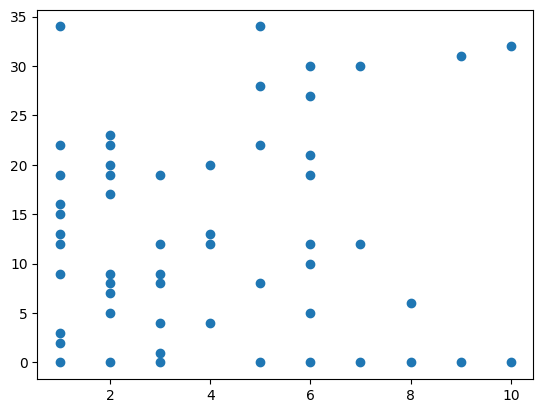

In [5]:
plt.scatter([i.loc[0] for i in shortened_network.nodes], [i.loc[1] for i in shortened_network.nodes])

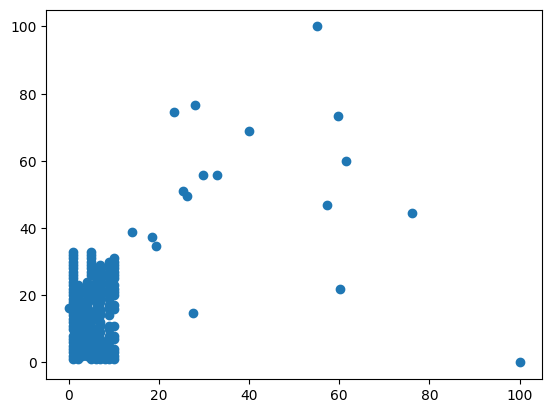

In [8]:
plt.scatter([i.loc[0] for i in complete_network.nodes], [i.loc[1] for i in complete_network.nodes])

In [9]:
edge_ids = [(i.id, i.weight) for i in shortened_network.edges]
target_weights = {i[0]: 1 for i in edge_ids}

In [35]:
def error(network):
    error_vector = [(i.weight - 1.5)**2 for i in network.edges]
    average_error = sum(error_vector)/len(error_vector)
    return average_error**0.5
dirs = {1:(1,0), 2:(0,1), 3:(-1,0), 4:(0,-1)}
node_memory = {node.id : {'cycle' : itertools.cycle(dirs.values()),
                          'back_counter' : 0} for node in complete_network.nodes}

def cardinal_move(node,eps,weight):
    if node_memory[node.id]['back_counter'] > 1000:
        return 'stuck'
    dir = next(node_memory[node.id]['cycle'])
    node.move(eps * dir[0], eps * dir[1], True)
    new_weight = error(complete_network)
    if new_weight > weight:
        node.move(-eps * dir[0],- eps * dir[1], True)
        node_memory[node.id]['back_counter'] += 1
    else:
        node_memory[node.id]['back_counter'] = 0

In [36]:
with open('End_Stations_Coordinates_clean.json', 'r') as fp: # Load path for top 10 song data for each artist in our dataset
    end_coords = json.load(fp)

In [41]:
nodes_copy = [i for i in complete_network.nodes]

In [37]:
pile = complete_network.nodes[:]
for key, value in end_coords.items():
    x = name_to_node.get(key)
    y = complete_network._node_translator[x]
    pile.remove(y)
    y.move(value[0],value[1],rel=False)

In [38]:
for i in tqdm(range(10000)):
    for node in pile:

        x = cardinal_move(node,0.01,error(complete_network))
        if x == 'stuck':
            pile.remove(node)
            break

100%|██████████| 10000/10000 [07:05<00:00, 23.49it/s]


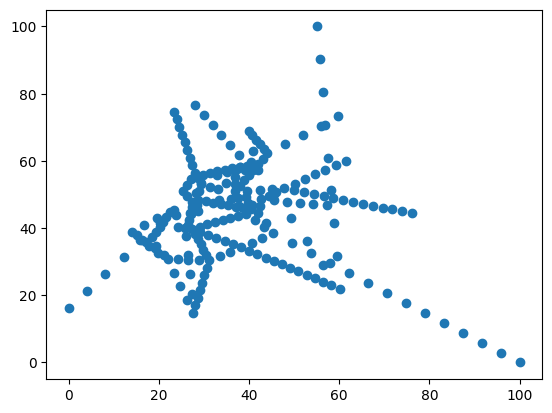

In [39]:
plt.scatter([i.loc[0] for i in complete_network.nodes], [i.loc[1] for i in complete_network.nodes])

In [100]:
# Assign line to each node

line_to_name = {}
for line,values in line_dict.items():
    stations = set()
    for station in values:
        stations.add(station[0])
    line_to_name[line] = stations
line_to_node_id = {key : [name_to_node.get(i,None) for i in value if name_to_node.get(i,None)] for key, value in line_to_name.items()}
line_to_node = { key : [complete_network._node_translator[i] for i in value] for key, value in line_to_node_id.items()}
for key, val in line_to_node.items():
    for i in val:
        try:
            i.line
        except:
            i.line = key

In [106]:
for i in complete_network.nodes:
    try:
        i.line
    except:
        complete_network.nodes.remove(i)
node_data = []
for i in complete_network.nodes:
    node_data.append([i.line,i.name,i.loc[0],i.loc[1],i.id])
lines_node_correspondence = pd.DataFrame(node_data,columns = ['line','station_name','x_coord','y_coord','node_id'])

In [110]:
lines_node_correspondence.to_csv('lines_node_correspondence.csv')

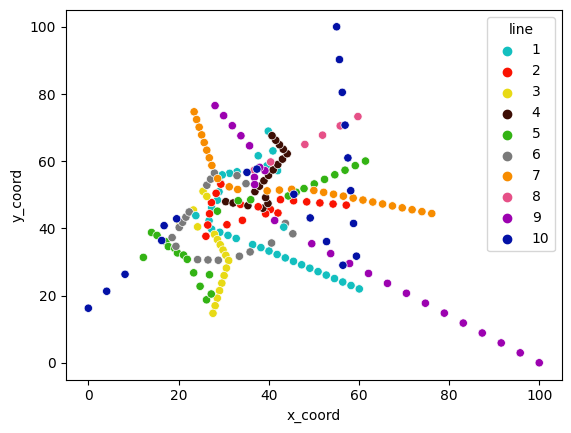

In [118]:
palette ={1: "#13bfbf", 2: "#fa1302", 3: "#e8da15", 4: "#3d0e05",5: "#33b314", 6: "#7a7a7a", 7: "#f78c00", 8: "#e65087", 9: "#9c02b0", 10: "#0311a6"}
sns.scatterplot(data=lines_node_correspondence, x='x_coord', y='y_coord', hue='line', palette=palette)
plt.savefig('final_metro.png')
plt.show()

<img src="metro_madrid_real.png" width=800 height=973 />